In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0,"../src")

In [3]:
import pandas as pd
import numpy as np

from fastai2 import *
from fastai2.text.all import *
import vectorize
import helpers
import transformers
from utils import *
from loss.loss import *

# Load the data

In [4]:
full_df = pd.read_pickle("../data/full_df.pkl")

In [5]:
MAX_VOCAB = None
MAX_SEQ_LENGTH = 5000
full_df['TEXT_PROCESSED'] = vectorize.clean_notes(full_df, 'TEXT')

In [6]:
full_df['ICD9_GRP_LIST'] = full_df.ICD9_GRP.apply(lambda x: re.split(" +", x.strip()))

# Training

Create Item Transformations

In [7]:
from transformers import BertConfig, BertForSequenceClassification, BertModel, BertTokenizer
bert_tok = BertTokenizer.from_pretrained(
 "bert-base-uncased",
)

fastai_bert_vocab =L(bert_tok.vocab.keys())

In [8]:
sample_df = full_df.sample(frac=1.0)

In [9]:
# For normal LSTM we don't need attention mask. We can set fill_to_max = False
# For Attention LSTM we need it . Set fill_to_max = True

item_tfms= [[ColReader('TEXT_PROCESSED'), FastAIBertTokenizer(tokenizer=bert_tok,max_seq_len=5000,fill_to_max=False)],
            [ColReader('ICD9_GRP_LIST') , MultiCategorize, OneHotEncode]
           ]

# Create datasource & dataloaders 

splits = RandomSplitter()(range_of(sample_df))
dsrc = Datasets(sample_df, tfms=item_tfms, splits=splits)
dls = dsrc.dataloaders(bs=16)

Testing dataloaders

In [10]:
b = dls.one_batch()

Showing batch

In [11]:
@typedispatch
def show_batch(x, y, samples, ctxs=None, max_n=9, **kwargs):
    if ctxs is None: ctxs = Inf.nones
    
    # samples[0] contains str , samples[1] contains str
    text_samples = []
    label_samples = []
    for i in range_of(samples):
        text_samples.append(samples[i][0][0][300:500])
        actual_labels = [l for l in samples[i][1] if l != ""]
        label_samples.append(actual_labels)
    
    df = pd.DataFrame({'Text': text_samples, 'Label': label_samples})
    display_df(df)

    return ctxs

In [12]:
@typedispatch
def show_results(x, y, samples, outs, ctxs=None, max_n=9, **kwargs):
    if ctxs is None: ctxs = Inf.nones
        
        # samples[0] contains str , samples[1] contains str
    text_samples = []
    label_samples = []
    result_samples = []
    for i in range_of(samples):
        text_samples.append(samples[i][0][0][300:500])
        actual_labels = [l for l in samples[i][1] if l != ""]
        label_samples.append(actual_labels)
        result_samples.append(outs[i][0])
    df = pd.DataFrame({'Text': text_samples, 'Label': label_samples,'Result': result_samples})
    display_df(df)
    
    return ctxs

In [13]:
dls.show_batch(b)

,Text,Label
0,llness dg y o woman w sclc metastatic s p xrt chemo with recent non response to chemotherapy admitted to with dyspnea she was found to have a right upper lobe collapse and a pleural effusion a pleurex,"[140-239, 240-279, 290-319, 320-389, 390-459, 460-519, 680-709, 800-999]"
1,as s p mvr on anticoagulation severe copd and cryptogenic cirrhosis who presented from osh with hyponatremia and change in mental status transferred to ccu for sob on review of discharge summary from,"[240-279, 390-459, 460-519, 520-579, 580-629, 680-709, 780-789]"
2,vc filter recurrent uti advanced dementia who comes in from nh after being found unresponsive she was reportedly unresponsive for dg dgm and hypoxic at dg put on nrb and was dg so was brought in repor,"[240-279, 290-319, 320-389, 390-459]"
3,ng admissions in and of obscure overt with last egd gastritis duodenitis with erosions but no frank ulcers diverticulosis atrial fibrillation on coumadin chf preserved ef with dg mr who presents with,"[001-139, 240-279, 290-319, 320-389, 390-459, 680-709]"
4,gm with history of alcohol abuse bcc fungal pericarditis hypopharyngeal cancer currently undergoing xrt who presents with fevers respiratory distress and transferred to the icu for close monitoring pt,"[001-139, 140-239, 240-279, 290-319, 320-389, 390-459, 460-519, 780-789, 790-796, 799, 800-999]"
5,tion to his usual dg mg around dg dg a m the patient fell out of bed with continued snoring his heart rate was dg dg with variable respiratory rate the patient seemed to be short of breath oxygen was,"[240-279, 290-319, 390-459, 460-519, 780-789, 800-999]"
6,vessel balloon angioplasty with no stents htn hypercholesterolemia h o v fib arrest in dm who presented to osh after witnessed episode of syncope lasting dg minutes ems called by wife the ems found p,"[240-279, 290-319, 390-459, 780-789]"
7,dg hours vomited x dg at scene awake on ems arrival c o headache dizziness taken by ems to osh neurologically intact found to have stable cdg fracture was transferred to for further evaluation and st,"[390-459, 520-579, 800-999]"
8,emale with a history of etoh abuse untreated hcv likely cirrhosis grade i esophageal varices esophagitis and gave on endoscopy and recent hospitalization for c diff colitis presents with persistent ab,"[001-139, 290-319, 390-459, 520-579, 780-789]"


# Modelling

In [14]:
from models.lstm_attn import *
from models.lstm import *
from models.bert_clinical import *
from loss.loss import *
from fastai2.metrics import *
from transformers import BertModel, BertConfig
from utils import *

In [15]:
V = len(fastai_bert_vocab)
E = 200
C = len(dsrc.tfms[1].vocab)

In [17]:
#load_wordvectors(glove_path)
glove_path = "../data"
#weights_matrix = get_glove_matrix(glove_path, fastai_bert_vocab, emb_dim=E)

In [18]:
# Loss function
loss_func = ICD_Loss(ignore_index=0)

# Metrics
acc_02 = partial(accuracy_multi, thresh=0.5)
f_score = F1ScoreMulti(thresh=0.5)

# Configuration
config = BertConfig.from_pretrained('bert-base-uncased') 

# Model
#model = BertClinical(config, C)
#model = BiLSTMWithBertEmbedding(config,V=V, E=E, C=C)
#model = SelfAttentionLSTM(V=V, E=E, C=C, weights_matrix=weights_matrix)
model = SelfAttentionLSTM(V=V, E=E, C=C, weights_matrix=None)


In [19]:
learn = Learner(dls, model, loss_func = loss_func, metrics=[acc_02, f_score])

(0.014454397559165954, 0.0012022644514217973)

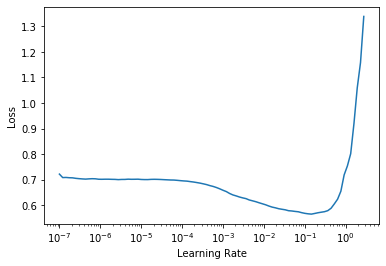

In [39]:
learn.lr_find()

In [40]:
learn.fit_one_cycle(1, lr_max=4*10e-3)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.311528,0.292058,0.873233,0.496575,27:38


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


In [42]:
learn.save('1epoch')

(0.014454397559165954, 3.6307804407442745e-07)

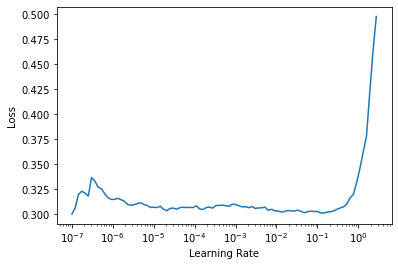

In [43]:
learn.lr_find()

In [ ]:
learn.save('3epoch_again')

In [20]:
learn.load("10epoch")

In [ ]:
learn.load('3epoch_again')

In [44]:
learn.fit_one_cycle(3, lr_max=3*10e-3)
learn.save('3epoch_after')

epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.318507,0.302150,0.868082,0.481341,27:35
1,0.309471,0.290448,0.874172,0.502943,27:45
2,0.281495,0.277936,0.881284,0.522471,27:52


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


(2.0892961401841602e-06, 3.019951861915615e-07)

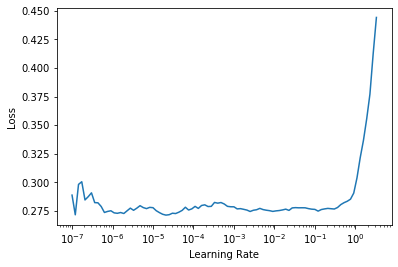

In [32]:
learn.lr_find()

In [33]:
learn.fit_one_cycle(3, lr_max=3*10e-3)
learn.save('4epoch_after')

epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.313616,0.304200,0.866230,0.485137,35:41
1,0.306687,0.289466,0.875344,0.501721,35:54
2,0.276990,0.276839,0.882013,0.522568,35:55


In [20]:
learn.load('3epoch_after')

# Show results

In [ ]:
learn.recorder.plot_loss()

In [21]:
learn.show_results()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


,Text,Label,Result
0,c attack nonischemic cardiomyopathy ef dg dg s p ventricular fibrillation arrest with clean coronaries at that time and s p aicd placement who presents as a transfer from osh for management of bactere,"[001-139, 290-319, 390-459, 580-629, 800-999]","[001-139, 240-279, 290-319, 320-389, 390-459, 460-519, 520-579, 580-629, 710-739, 780-789, 790-796, 800-999]"
1,sided weakness the patient has had a right ear lesion removed with unknown pathology physical examination the patient was awake and alert with aphasia good comprehension following multi step commands,"[140-239, 320-389, 390-459, 780-789]","[140-239, 240-279, 290-319, 390-459, 780-789]"
2,ure percutaneous tracheostomy placement dg portex cuffed with inner cannula past medical history pmh htn dyslipidemia hypothyroidism diverticulitis colon ca large ventral and parastomal hernias chroni,"[240-279, 390-459, 460-519, 520-579, 580-629, 710-739, 780-789]","[001-139, 240-279, 290-319, 320-389, 390-459, 460-519, 520-579, 580-629, 680-709, 710-739, 780-789, 800-999]"
3,to the hospital from wtih hypoglycemia he was evaluated by endocrinology at that time and the most likely etiology of his hypoglycemia was felt to be pre diabetes causing hyperinsulinemia work up reve,"[240-279, 290-319, 390-459, 460-519, 580-629, 800-999]","[240-279, 290-319, 320-389, 390-459, 460-519, 580-629, 780-789]"
4,ronic obstructive pulmonary disease severe refractory hypertension type dg diabetes mellitus and chronic renal insufficiency who presents from rehabilitation followed there by the pulmonary interventi,"[240-279, 390-459, 460-519, 580-629, 680-709]","[001-139, 240-279, 290-319, 390-459, 460-519, 580-629, 680-709, 780-789, 800-999]"
5,ater with greater than dg bowel movements a day for one day one day prior to admission had weakness when standing also had temperature of dg decreased p o's after arrival in the emergency department u,"[001-139, 240-279, 390-459, 580-629, 800-999]","[001-139, 240-279, 290-319, 390-459, 520-579, 580-629, 710-739, 780-789, 800-999]"
6,presents with upper gastrointestinal bleed the patient had developed hematemesis with coffee grounds he has a history of upper gi bleed with nsaids in and he recently started taking aspirin esophagog,"[001-139, 290-319, 390-459, 520-579, 680-709, 800-999]","[240-279, 290-319, 390-459, 520-579, 580-629, 680-709, 710-739, 780-789]"
7,t for coronary artery disease with multiple stents to lcx and lad diabetes hypertension who was admitted two months ago for gi bleed and nstemi and now presents from osh with chest pain this morning h,"[240-279, 290-319, 390-459, 460-519, 520-579, 580-629]","[240-279, 290-319, 390-459, 460-519, 520-579, 580-629, 780-789, 800-999]"
8,de hospital after he presented with expressive aphagia on in the setting of profound thrombocytopenia a head ct he was transferred to the micu in the micu a neurosurgery consult was obtained the neuro,"[140-239, 240-279, 390-459, 710-739, 780-789]","[140-239, 240-279, 290-319, 390-459, 520-579, 580-629, 780-789, 800-999]"


In [31]:
#preds,targs = learn.get_preds()


In [25]:
preds_copy = preds.detach()

In [26]:
preds_copy[preds_copy> 0.5] = 1
preds_copy[preds_copy<=0.5] = 0

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score, multilabel_confusion_matrix, classification_report


In [28]:
multilabel_confusion_matrix(targs, preds_copy)

array([[[10542,     0],
        [    2,     0]],

       [[ 7409,   367],
        [ 1049,  1719]],

       [[ 8678,   124],
        [  524,  1218]],

       [[ 2224,  1330],
        [  604,  6386]],

       [[ 3794,  1165],
        [ 1238,  4347]],

       [[ 7005,   437],
        [ 1444,  1658]],

       [[ 1481,   725],
        [  282,  8056]],

       [[ 5101,   492],
        [ 1068,  3883]],

       [[ 5953,   450],
        [ 1086,  3055]],

       [[ 5821,   465],
        [ 1121,  3137]],

       [[10518,     0],
        [   26,     0]],

       [[ 9261,    78],
        [  826,   379]],

       [[ 8430,   196],
        [ 1227,   691]],

       [[ 9487,     3],
        [  332,   722]],

       [[ 6774,   535],
        [ 2214,  1021]],

       [[ 9674,     1],
        [  867,     2]],

       [[10544,     0],
        [    0,     0]],

       [[10239,     0],
        [  305,     0]],

       [[ 5536,   609],
        [ 1524,  2875]]])

In [29]:
print(classification_report(targs, preds_copy))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.82      0.62      0.71      2768
           2       0.91      0.70      0.79      1742
           3       0.83      0.91      0.87      6990
           4       0.79      0.78      0.78      5585
           5       0.79      0.53      0.64      3102
           6       0.92      0.97      0.94      8338
           7       0.89      0.78      0.83      4951
           8       0.87      0.74      0.80      4141
           9       0.87      0.74      0.80      4258
          10       0.00      0.00      0.00        26
          11       0.83      0.31      0.46      1205
          12       0.78      0.36      0.49      1918
          13       1.00      0.69      0.81      1054
          14       0.66      0.32      0.43      3235
          15       0.67      0.00      0.00       869
          16       0.00      0.00      0.00         0
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    inp,targ = flatten_check(inp,targ)
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [ ]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)


In [ ]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

SelfAttentionWithLSTM

3 epoch:

10 epoch:



# Inference

In [ ]:
def predict(txt):
    processed_items = TfmdLists([txt], tfms=FastAIBertTokenizer(tokenizer=bert_tok))
    print(processed_items)
    tags = learn.predict(processed_items[0],with_input=True)
    #for k,v in zip(tags[0][0], tags[1][0]):
    #    print(k, v)

In [ ]:
item="Cardio vascular therapy"
predict(item)

In [ ]:
%debug

In [ ]:
item="Cardio vascular therapy"
test = pd.DataFrame({"TEXT_PROCESSED": [item], "ICD9_GRP_LIST":[""]})
test.head()
learn.predict(item)